# Simulate traditional reservoir network response to song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings

from disp import set_plot
from my_stats import nanpearsonr

warnings.filterwarnings("ignore")

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NNRN = 224

SAVE_DIR = f'data/simple/mlv/res_comp/res_comp'
PFX = 'res_comp'

## Coen et al data

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(n_tr)]
df_behav = None

In [4]:
def smlt_rsvr(i_s, i_p, params, dt):
    w_rec = params['w_rec']
    w_in = params['w_in']
    tau = params['tau']
    
    hs = np.nan*np.zeros((len(i_s), w_rec.shape[0]))
    hs[0, :] = 0
    
    rs = np.nan*np.zeros((len(i_s), w_rec.shape[0]))
    rs[0, :] = np.tanh(hs[0, :])
    
    for t_ in range(1, len(i_s)):
        h = hs[t_-1, :]
        u = np.array([i_s[t_], i_p[t_]])
#         dh = (dt/tau)*(-h + np.tanh(w_rec@h + w_in@u))
        dh = (dt/tau)*(-h + w_rec@np.tanh(h) + w_in@u)
        hs[t_] = h + dh
        rs[t_] = np.tanh(hs[t_])
        
    return rs

# Main loop

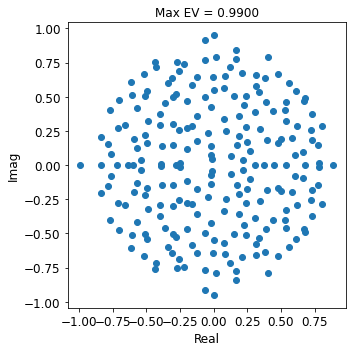

In [5]:
RADIUS = .99  # spectral radius
TAU = 1  # neural time constant

w_rec = np.random.randn(NNRN, NNRN)/np.sqrt(NNRN)
evs = np.linalg.eig(w_rec)[0]

# rescale to have desired spectral radius
w_rec *= (RADIUS/np.max(np.abs(evs)))
evs = np.linalg.eig(w_rec)[0]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.scatter(np.real(evs), np.imag(evs))
set_plot(ax, x_label='Real', y_label='Imag', title=f'Max EV = {np.max(np.abs(evs)):.4f}')

w_in = np.random.randn(NNRN, 2)/np.sqrt(2)

params = {'w_rec': w_rec, 'w_in': w_in, 'tau': TAU}

...

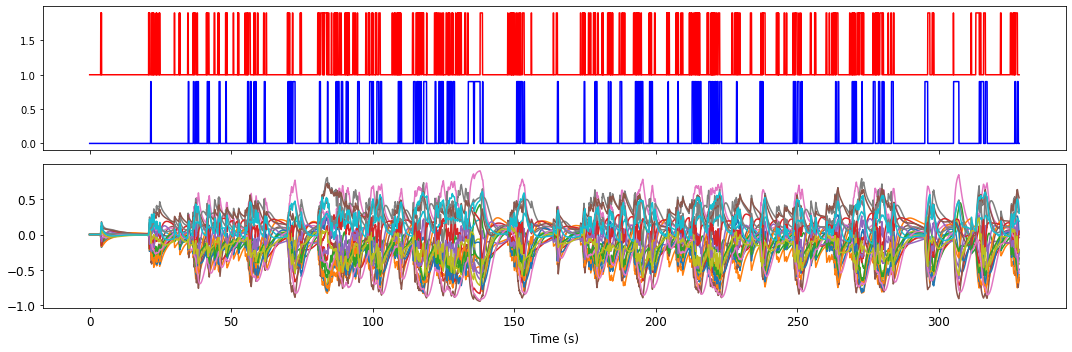

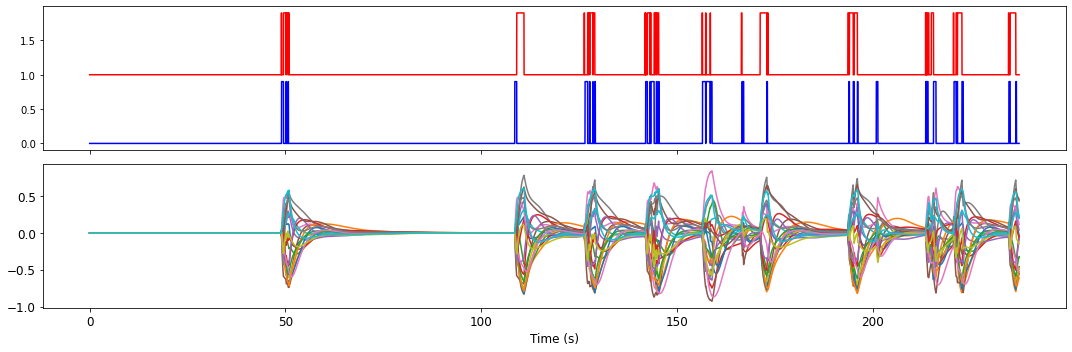

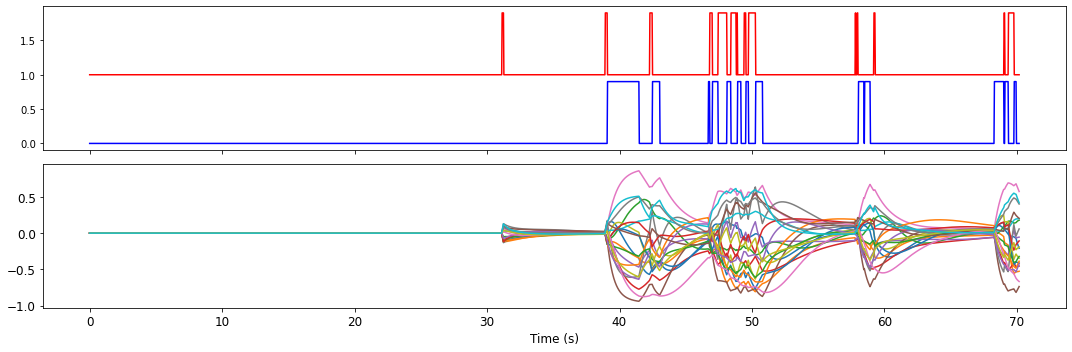

In [6]:
# loop over trials passing each song through reservoir computer
for ctr, df_tr in enumerate(dfs_tr[:3]):
    sys.stdout.write('.')
    
    # song
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    df_tr_res_comp = df_tr.copy()
    rs = smlt_rsvr(i_s, i_p, params, DT)
    
    t = np.arange(len(i_s))*DT
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True, sharex=True)
    axs[0].plot(t, .9*i_s, c='b')
    axs[0].plot(t, .9*i_p+1, c='r')
    
    axs[1].plot(t, rs[:, :20])
    
    set_plot(axs[1], x_label='Time (s)')